# PTB-XL Rhythm and Form (Morphology) Analysis

Expert-focused EDA of arrhythmia (rhythm) and morphology (form) label spaces in PTB-XL to inform stand-alone or multi-task classification.

Outline:
- 0) Environment and configuration
- 1) Load metadata and parse rhythm/form taxonomies
- 2) Prevalence, multi-label metrics, and imbalance (IRLbl)
- 3) Intra-axis co-occurrence and conditional P(i|j)
- 4) Cross-axis associations: rhythm×form PMI and conditional
- 5) Demographic associations (sex, age bands)
- 6) Domain shift by device/site
- 7) Temporal trends for frequent labels
- 8) Waveform-derived features on a subset
- 9) Waveform galleries per label
- 10) Recommendations for rhythm/form modeling



## 0) Environment and configuration

Why this matters:
- Keep paths and options centralized and reproducible. Waveform sections gracefully skip if `wfdb` is missing.



In [1]:
import os
import ast
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import wfdb
except Exception:
    wfdb = None
    warnings.warn("wfdb not installed; waveform sections will be skipped.")

for style_name in ['seaborn-v0_8-whitegrid', 'seaborn-whitegrid', 'seaborn']:
    try:
        plt.style.use(style_name)
        break
    except Exception:
        continue

DATA_ROOT = os.path.abspath("data/ptb-xl/")
DB_CSV = os.path.join(DATA_ROOT, "ptbxl_database.csv")
SCP_CSV = os.path.join(DATA_ROOT, "scp_statements.csv")

assert os.path.exists(DB_CSV), f"Missing {DB_CSV}"
assert os.path.exists(SCP_CSV), f"Missing {SCP_CSV}"
print("Using DATA_ROOT:", DATA_ROOT)


Using DATA_ROOT: /mnt/hdd1/yasser/code/ecg/data/ptb-xl


## 1) Load metadata and parse rhythm/form taxonomies

Why this matters:
- Rhythm and form are orthogonal axes to diagnostics; they power arrhythmia and morphology pipelines.



In [2]:
ptbxl_df = pd.read_csv(DB_CSV)
scp_df = pd.read_csv(SCP_CSV, index_col=0)

# Parse SCP code dicts
ptbxl_df['scp_codes_dict'] = ptbxl_df['scp_codes'].apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else {})

# Identify rhythm and form codes
rhythm_codes = scp_df.index[scp_df['rhythm'] == 1].tolist()
form_codes   = scp_df.index[scp_df['form'] == 1].tolist()

# Extract lists per record
ptbxl_df['labels_rhythm'] = ptbxl_df['scp_codes_dict'].apply(lambda d: sorted([c for c in d.keys() if c in rhythm_codes]))
ptbxl_df['labels_form']   = ptbxl_df['scp_codes_dict'].apply(lambda d: sorted([c for c in d.keys() if c in form_codes]))

# Build multi-hot matrices for rhythm and form
all_rhythm = sorted(set([c for lst in ptbxl_df['labels_rhythm'] for c in lst]))
all_form   = sorted(set([c for lst in ptbxl_df['labels_form'] for c in lst]))

rhythm_to_idx = {c: i for i, c in enumerate(all_rhythm)}
form_to_idx   = {c: i for i, c in enumerate(all_form)}

Y_rhythm = np.zeros((len(ptbxl_df), len(all_rhythm)), dtype=int)
Y_form   = np.zeros((len(ptbxl_df), len(all_form)), dtype=int)

for i, codes in enumerate(ptbxl_df['labels_rhythm']):
    for c in codes:
        Y_rhythm[i, rhythm_to_idx[c]] = 1

for i, codes in enumerate(ptbxl_df['labels_form']):
    for c in codes:
        Y_form[i, form_to_idx[c]] = 1

print(f"Rhythm labels: {len(all_rhythm)} | Form labels: {len(all_form)}")
ptbxl_df.head(3)[['ecg_id','labels_rhythm','labels_form']]


Rhythm labels: 12 | Form labels: 19


,ecg_id,labels_rhythm,labels_form
0,1,[SR],[LVOLT]
1,2,[SBRAD],[]
2,3,[SR],[]


## 2) Prevalence, multi-label metrics, and imbalance (IRLbl)

Why this matters:
- Long-tail labels require weighting and careful thresholding; we quantify imbalance and multi-label properties.



Rhythm labels: 12 | cardinality=0.971
Form labels:   19   | cardinality=0.551


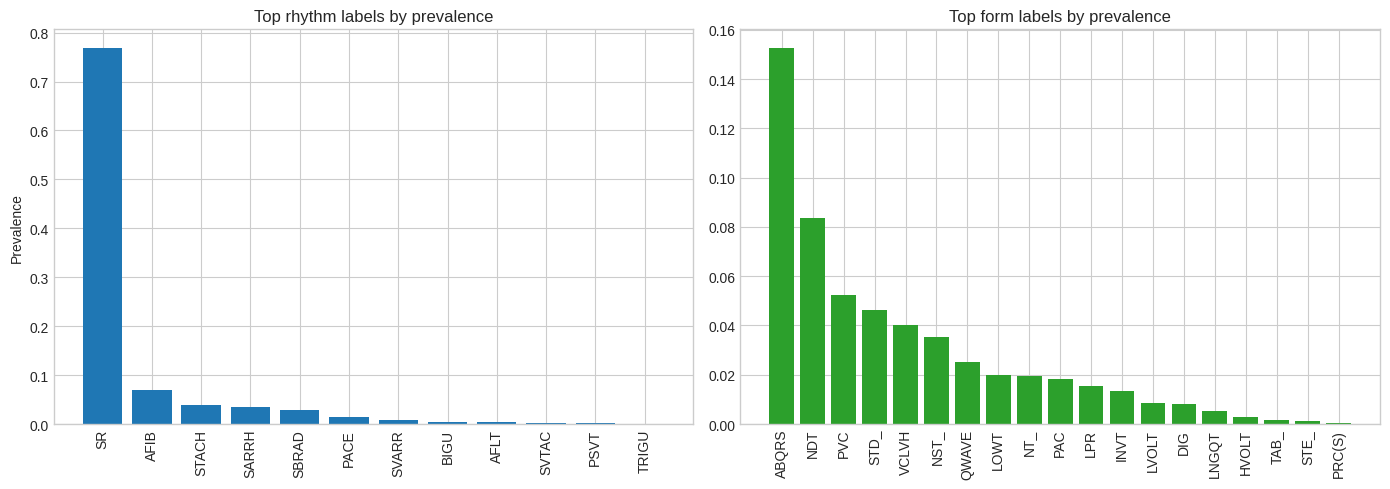

Imbalance (IRLbl) rhythm top-N:


,label,prevalence,IRLbl
0,SR,0.768292,1.000000
1,AFIB,0.069453,11.062087
2,STACH,0.037892,20.276029
3,SARRH,0.035414,21.694301
4,SBRAD,0.029222,26.291994
5,PACE,0.013487,56.965986
6,SVARR,0.007202,106.675159
7,BIGU,0.003762,204.243902
8,AFLT,0.003349,229.424658
9,SVTAC,0.001239,620.296296


Imbalance (IRLbl) form top-N:


,label,prevalence,IRLbl
0,ABQRS,0.152622,1.000000
1,NDT,0.083719,1.823014
2,PVC,0.052434,2.910761
3,STD_,0.046287,3.297324
4,VCLVH,0.040139,3.802286
5,NST_,0.035185,4.337679
6,QWAVE,0.025139,6.071168
7,LOWT,0.020093,7.595890
8,NT_,0.019405,7.865248
9,PAC,0.018258,8.359296


In [3]:
def prevalence(Y):
    return Y.mean(axis=0)

def label_cardinality(Y):
    return Y.sum(axis=1).mean()

def imbalance_ratio(Y):
    p = prevalence(Y)
    p = np.clip(p, 1e-9, 1.0)
    max_p = p.max()
    return max_p / p  # IRLbl per label

prev_rhythm = prevalence(Y_rhythm)
prev_form   = prevalence(Y_form)

print(f"Rhythm labels: {len(all_rhythm)} | cardinality={label_cardinality(Y_rhythm):.3f}")
print(f"Form labels:   {len(all_form)}   | cardinality={label_cardinality(Y_form):.3f}")

# Top-N frequent labels for rhythm and form
N = 20
idx_rhythm = np.argsort(prev_rhythm)[::-1][:N]
idx_form   = np.argsort(prev_form)[::-1][:N]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar([all_rhythm[i] for i in idx_rhythm], prev_rhythm[idx_rhythm], color='tab:blue')
axes[0].set_title('Top rhythm labels by prevalence')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_ylabel('Prevalence')

axes[1].bar([all_form[i] for i in idx_form], prev_form[idx_form], color='tab:green')
axes[1].set_title('Top form labels by prevalence')
axes[1].tick_params(axis='x', rotation=90)
plt.tight_layout(); plt.show()

# Imbalance ratios tables for the top labels
ir_rhythm = imbalance_ratio(Y_rhythm)
ir_form   = imbalance_ratio(Y_form)

df_ir_rhythm = pd.DataFrame({'label':[all_rhythm[i] for i in idx_rhythm], 'prevalence':prev_rhythm[idx_rhythm], 'IRLbl':ir_rhythm[idx_rhythm]})
df_ir_form   = pd.DataFrame({'label':[all_form[i] for i in idx_form], 'prevalence':prev_form[idx_form], 'IRLbl':ir_form[idx_form]})
print('Imbalance (IRLbl) rhythm top-N:')
display(df_ir_rhythm)
print('Imbalance (IRLbl) form top-N:')
display(df_ir_form)


## 3) Intra-axis co-occurrence and conditional P(i|j)

Why this matters:
- Reveals label dependencies within rhythm and within form; informs structured losses and heads.



ValueError: The number of FixedLocator locations (25), usually from a call to set_ticks, does not match the number of labels (12).

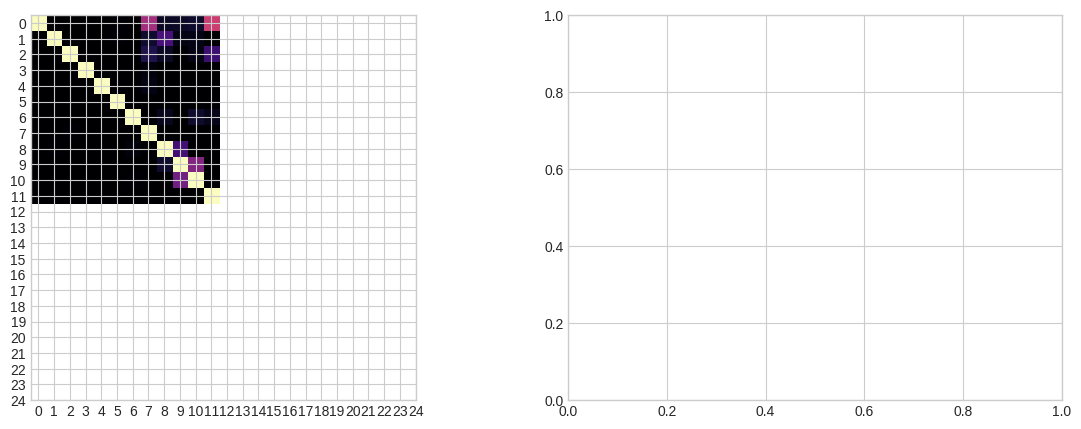

In [4]:
def conditional_matrix(Y, labels):
    C = Y.T @ Y
    marg = Y.sum(axis=0).clip(min=1)
    Pcond = C / marg[np.newaxis, :]
    return C, Pcond

C_rhythm, P_rhythm = conditional_matrix(Y_rhythm, all_rhythm)
C_form,   P_form   = conditional_matrix(Y_form, all_form)

# Visualize P(i|j) for top-K by prevalence
K = 25
idx_r = np.argsort(prev_rhythm)[::-1][:K]
idx_f = np.argsort(prev_form)[::-1][:K]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes[0]
cax = ax.imshow(P_rhythm[np.ix_(idx_r, idx_r)], cmap='magma', vmin=0, vmax=1)
ax.set_xticks(range(K)); ax.set_yticks(range(K))
ax.set_xticklabels([all_rhythm[i] for i in idx_r], rotation=90)
ax.set_yticklabels([all_rhythm[i] for i in idx_r])
ax.set_title('Rhythm P(i|j) (top-K)')
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.02)

ax = axes[1]
cax = ax.imshow(P_form[np.ix_(idx_f, idx_f)], cmap='viridis', vmin=0, vmax=1)
ax.set_xticks(range(K)); ax.set_yticks(range(K))
ax.set_xticklabels([all_form[i] for i in idx_f], rotation=90)
ax.set_yticklabels([all_form[i] for i in idx_f])
ax.set_title('Form P(i|j) (top-K)')
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.02)
plt.tight_layout(); plt.show()


## 4) Cross-axis associations: rhythm×form PMI and conditional

Why this matters:
- Rhythm and form often co-occur (e.g., AF with ST/T changes). Quantifying associations informs multi-task heads and priors.



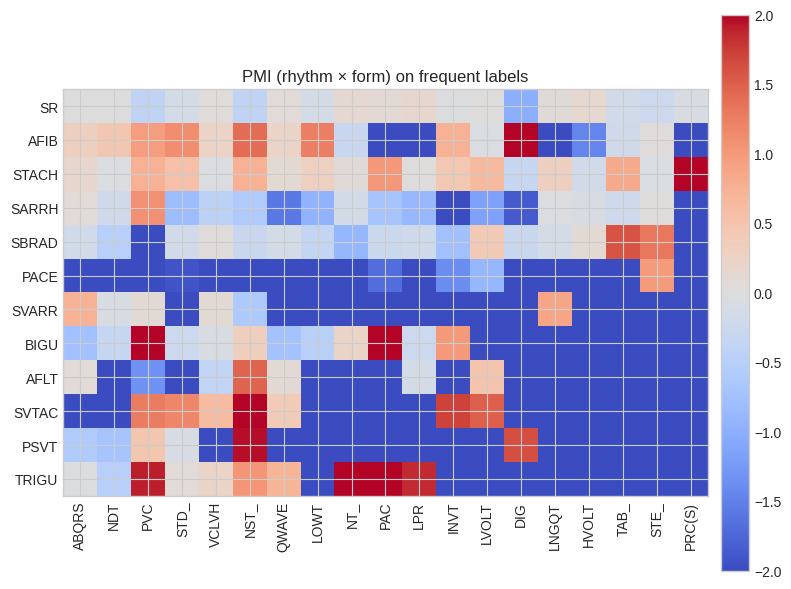

Top P(form|rhythm) for a few rhythms:
SR


ABQRS    0.151302
NDT      0.082458
VCLVH    0.041975
STD_     0.040662
PVC      0.035049
QWAVE    0.026809
NST_     0.023465
NT_      0.021734
PAC      0.019823
LPR      0.018510
dtype: float64

AFIB


ABQRS    0.206077
NST_     0.143329
STD_     0.138705
PVC      0.135403
NDT      0.130779
DIG      0.075958
LOWT     0.070013
VCLVH    0.050859
QWAVE    0.031704
INVT     0.028402
dtype: float64

STACH


ABQRS    0.180387
PVC      0.108959
NDT      0.081114
STD_     0.081114
NST_     0.072639
PAC      0.049637
VCLVH    0.038741
QWAVE    0.027845
LOWT     0.026634
NT_      0.020581
dtype: float64

SARRH


ABQRS    0.163212
PVC      0.154145
NDT      0.068653
VCLVH    0.025907
STD_     0.020725
NST_     0.019430
NT_      0.016839
PAC      0.009067
LOWT     0.007772
LPR      0.006477
dtype: float64

SBRAD


ABQRS    0.130298
NDT      0.050235
VCLVH    0.040816
STD_     0.039246
NST_     0.026688
QWAVE    0.021978
LOWT     0.014129
PAC      0.014129
LPR      0.012559
LVOLT    0.012559
dtype: float64

Top P(rhythm|form) for a few forms:
ABQRS


SR       0.761647
AFIB     0.093778
STACH    0.044785
SARRH    0.037872
SBRAD    0.024947
SVARR    0.015029
AFLT     0.003607
BIGU     0.001803
TRIGU    0.000902
PACE     0.000601
dtype: float64

NDT


SR       0.756712
AFIB     0.108493
STACH    0.036712
SARRH    0.029041
SBRAD    0.017534
SVARR    0.006575
BIGU     0.002740
TRIGU    0.000548
PSVT     0.000548
PACE     0.000000
dtype: float64

PVC


SR       0.513561
AFIB     0.179353
SARRH    0.104112
STACH    0.078740
BIGU     0.035871
SVARR    0.007874
TRIGU    0.006124
SVTAC    0.004374
SBRAD    0.003500
PSVT     0.001750
dtype: float64

STD_


SR       0.674926
AFIB     0.208127
STACH    0.066402
SBRAD    0.024777
SARRH    0.015857
SVTAC    0.003964
BIGU     0.002973
PACE     0.001982
TRIGU    0.000991
PSVT     0.000991
dtype: float64

VCLVH


SR       0.803429
AFIB     0.088000
STACH    0.036571
SBRAD    0.029714
SARRH    0.022857
SVARR    0.008000
BIGU     0.003429
AFLT     0.002286
SVTAC    0.002286
TRIGU    0.001143
dtype: float64

In [5]:
# Compute PMI between rhythm (rows) and form (cols)
N = len(ptbxl_df)
pr = Y_rhythm.sum(axis=0) / N
pf = Y_form.sum(axis=0) / N
C_rf = Y_rhythm.T @ Y_form  # co-occurrence counts
p_rf = C_rf / N

EPS = 1e-9
PMI = np.log((p_rf + EPS) / ((pr[:, None] * pf[None, :]) + EPS))

# Visualize top rhythm×form pairs by PMI among frequent labels
top_r = np.argsort(pr)[::-1][:30]
top_f = np.argsort(pf)[::-1][:30]

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(PMI[np.ix_(top_r, top_f)], cmap='coolwarm', vmin=-2, vmax=2)
ax.set_xticks(range(len(top_f))); ax.set_yticks(range(len(top_r)))
ax.set_xticklabels([all_form[j] for j in top_f], rotation=90)
ax.set_yticklabels([all_rhythm[i] for i in top_r])
ax.set_title('PMI (rhythm × form) on frequent labels')
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.02)
plt.tight_layout(); plt.show()

# Conditional P(form|rhythm) and P(rhythm|form) for frequent sets
P_f_given_r = (C_rf / np.maximum(1, Y_rhythm.sum(axis=0))[:, None])
P_r_given_f = (C_rf.T / np.maximum(1, Y_form.sum(axis=0))[:, None])

print('Top P(form|rhythm) for a few rhythms:')
for i in top_r[:5]:
    series = pd.Series(P_f_given_r[i, top_f], index=[all_form[j] for j in top_f]).sort_values(ascending=False)[:10]
    print(all_rhythm[i]); display(series)

print('Top P(rhythm|form) for a few forms:')
for j in top_f[:5]:
    series = pd.Series(P_r_given_f[j, top_r], index=[all_rhythm[i] for i in top_r]).sort_values(ascending=False)[:10]
    print(all_form[j]); display(series)


## 5) Demographic associations (sex, age bands)

Why this matters:
- Fairness and potential confounding: label prevalence differences by sex/age can bias models.



ValueError: x and y must have same first dimension, but have shapes (15,) and (12,)

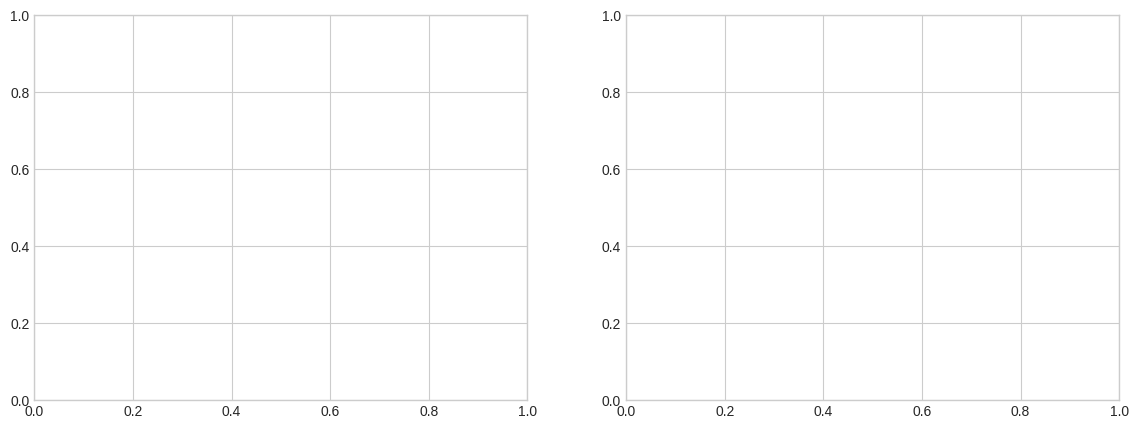

In [6]:
# Prepare demographics
ptbxl_df['age'] = pd.to_numeric(ptbxl_df['age'], errors='coerce')
ptbxl_df['sex'] = pd.to_numeric(ptbxl_df['sex'], errors='coerce')  # 0=female,1=male
age_bins = [0, 30, 45, 60, 75, 200]
age_labels = ['<30','30-44','45-59','60-74','75+']
ptbxl_df['age_band'] = pd.cut(ptbxl_df['age'], bins=age_bins, labels=age_labels, right=False)

# Mean prevalence per group for frequent labels
K = 15
idx_r = np.argsort(prev_rhythm)[::-1][:K]
idx_f = np.argsort(prev_form)[::-1][:K]

# Sex
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
for sex_val, ax, title in [(0, axes[0], 'female (0)'), (1, axes[1], 'male (1)')]:
    mask = ptbxl_df['sex'] == sex_val
    m_r = Y_rhythm[mask.fillna(False)].mean(axis=0)[idx_r]
    m_f = Y_form[mask.fillna(False)].mean(axis=0)[idx_f]
    ax.plot(range(K), m_r, marker='o', label='rhythm')
    ax.plot(range(K), m_f, marker='s', label='form')
    ax.set_title(f'Prevalence (top-K) by sex={title}')
    ax.set_xticks(range(K))
    ax.set_xticklabels([all_rhythm[i] for i in idx_r], rotation=90)
    ax.legend()
plt.tight_layout(); plt.show()

# Age bands
fig, axes = plt.subplots(1, len(age_labels), figsize=(3*len(age_labels), 4), sharey=True)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
for i, label in enumerate(age_labels):
    mask = ptbxl_df['age_band'] == label
    m_r = Y_rhythm[mask.fillna(False)].mean(axis=0)[idx_r]
    m_f = Y_form[mask.fillna(False)].mean(axis=0)[idx_f]
    axes[i].plot(range(K), m_r, marker='o', label='rhythm')
    axes[i].plot(range(K), m_f, marker='s', label='form')
    axes[i].set_title(f'{label}')
    axes[i].set_xticks(range(K))
    axes[i].set_xticklabels([all_rhythm[i] for i in idx_r], rotation=90)
    if i == 0:
        axes[i].legend()
plt.tight_layout(); plt.show()


## 6) Domain shift by device/site

Why this matters:
- Device/site shift affects rhythm and morphology detection; we quantify prevalence differences and visualize simple embeddings.



Rhythm prevalence by device (top):


,CS100 3,CS-12,AT-6 C 5.5,CS-12 E,AT-6 6,AT-60 3
SR,0.742182,0.730484,0.791899,0.872481,0.741311,0.732919
AFIB,0.098046,0.073123,0.063291,0.005212,0.069952,0.078675
STACH,0.024919,0.064476,0.035949,0.014593,0.057193,0.061077
SARRH,0.037459,0.030385,0.028101,0.068450,0.019358,0.049689
SBRAD,0.022150,0.064970,0.019241,0.023628,0.022437,0.023810
PACE,0.031596,0.005929,0.005823,0.000000,0.006599,0.008282
SVARR,0.021824,0.000000,0.000000,0.000000,0.000000,0.023810
BIGU,0.002932,0.006176,0.005063,0.000000,0.006599,0.002070
AFLT,0.003257,0.002964,0.004557,0.003475,0.002640,0.001035
SVTAC,0.000000,0.000247,0.003038,0.000000,0.003080,0.000000


Form prevalence by device (top):


,CS100 3,CS-12,AT-6 C 5.5,CS-12 E,AT-6 6,AT-60 3
ABQRS,0.333225,0.191947,0.000000,0.083739,0.000000,0.272257
NDT,0.077524,0.083498,0.103038,0.043433,0.104707,0.078675
PVC,0.071173,0.047184,0.057215,0.007992,0.050154,0.055901
STD_,0.000000,0.007411,0.132405,0.000000,0.130664,0.000000
VCLVH,0.043485,0.004694,0.072911,0.007992,0.061593,0.059006
NST_,0.019055,0.045455,0.050633,0.008687,0.056313,0.039337
QWAVE,0.000000,0.022480,0.067848,0.000000,0.058953,0.000000
LOWT,0.000000,0.000000,0.058481,0.000000,0.060713,0.000000
NT_,0.000000,0.000000,0.057975,0.000000,0.057633,0.000000
PAC,0.000977,0.002717,0.054177,0.001390,0.048394,0.000000


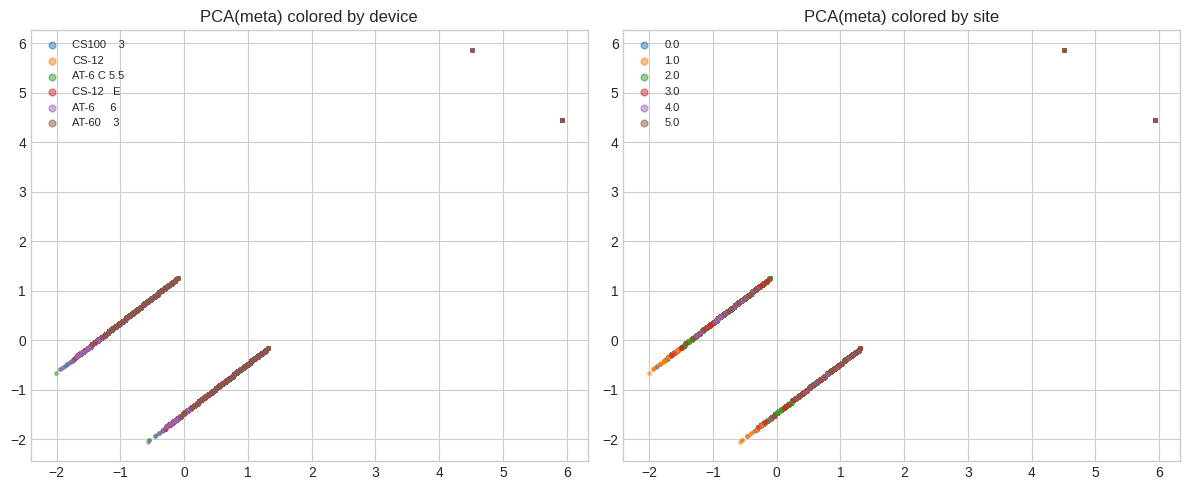

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ptbxl_df['baseline_drift'] = pd.to_numeric(ptbxl_df['baseline_drift'], errors='coerce')
ptbxl_df['static_noise'] = pd.to_numeric(ptbxl_df['static_noise'], errors='coerce')
ptbxl_df['burst_noise'] = pd.to_numeric(ptbxl_df['burst_noise'], errors='coerce')
ptbxl_df['electrodes_problems'] = pd.to_numeric(ptbxl_df['electrodes_problems'], errors='coerce')

meta_cols = ['age','sex','baseline_drift','static_noise','burst_noise','electrodes_problems']
X = ptbxl_df[meta_cols].fillna(0.0).to_numpy()
X = StandardScaler().fit_transform(X)
Z = PCA(n_components=2, random_state=0).fit_transform(X)

# Prevalence per device/site for top labels
top_devices = ptbxl_df['device'].value_counts().head(6).index.tolist()
top_sites = ptbxl_df['site'].value_counts().head(6).index.tolist()

# Rhythm prevalence per device/site
prev_rhythm_by_dev = {dev: Y_rhythm[ptbxl_df['device'] == dev].mean(axis=0) for dev in top_devices}
prev_rhythm_by_site = {s: Y_rhythm[ptbxl_df['site'] == s].mean(axis=0) for s in top_sites}

# Form prevalence per device/site
prev_form_by_dev = {dev: Y_form[ptbxl_df['device'] == dev].mean(axis=0) for dev in top_devices}
prev_form_by_site = {s: Y_form[ptbxl_df['site'] == s].mean(axis=0) for s in top_sites}

print('Rhythm prevalence by device (top):')
display(pd.DataFrame(prev_rhythm_by_dev, index=all_rhythm).iloc[idx_r])
print('Form prevalence by device (top):')
display(pd.DataFrame(prev_form_by_dev, index=all_form).iloc[idx_f])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for dev in top_devices:
    mask = ptbxl_df['device'] == dev
    axes[0].scatter(Z[mask, 0], Z[mask, 1], s=6, alpha=0.5, label=str(dev))
axes[0].set_title('PCA(meta) colored by device'); axes[0].legend(markerscale=2, fontsize=8, frameon=False)

for s in top_sites:
    mask = ptbxl_df['site'] == s
    axes[1].scatter(Z[mask, 0], Z[mask, 1], s=6, alpha=0.5, label=str(s))
axes[1].set_title('PCA(meta) colored by site'); axes[1].legend(markerscale=2, fontsize=8, frameon=False)
plt.tight_layout(); plt.show()


## 7) Temporal trends for selected frequent rhythm/form labels

Why this matters:
- Changes over acquisition years can imply practice or device shifts affecting prevalence.



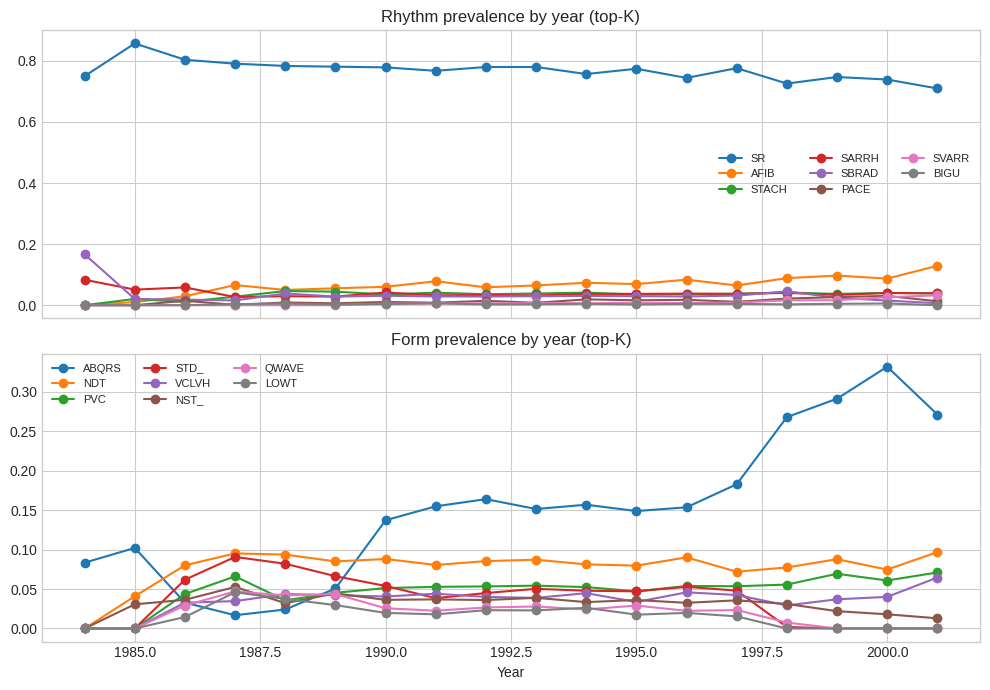

In [8]:
ptbxl_df['recording_date'] = pd.to_datetime(ptbxl_df['recording_date'], errors='coerce')
ptbxl_df['year'] = ptbxl_df['recording_date'].dt.year

K = 8
idx_r = np.argsort(prev_rhythm)[::-1][:K]
idx_f = np.argsort(prev_form)[::-1][:K]

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
for i, lab_idx in enumerate(idx_r):
    series = pd.Series(Y_rhythm[:, lab_idx], index=ptbxl_df['year']).groupby(level=0).mean().sort_index()
    axes[0].plot(series.index, series.values, marker='o', label=all_rhythm[lab_idx])
axes[0].set_title('Rhythm prevalence by year (top-K)'); axes[0].legend(fontsize=8, ncol=3)

for i, lab_idx in enumerate(idx_f):
    series = pd.Series(Y_form[:, lab_idx], index=ptbxl_df['year']).groupby(level=0).mean().sort_index()
    axes[1].plot(series.index, series.values, marker='o', label=all_form[lab_idx])
axes[1].set_title('Form prevalence by year (top-K)'); axes[1].legend(fontsize=8, ncol=3)
axes[1].set_xlabel('Year')
plt.tight_layout(); plt.show()


## 8) Waveform-derived features on a subset

Why this matters:
- Quick signal descriptors (per-lead std, zero-crossing rate, kurtosis) help compare rhythm vs form label patterns without full training.



In [ ]:
from scipy.stats import kurtosis

def read_signal(path):
    if wfdb is None:
        return None
    try:
        sig, meta = wfdb.rdsamp(path)
        return sig
    except Exception:
        return None

# Sample a manageable subset
subset = ptbxl_df.sample(n=min(400, len(ptbxl_df)), random_state=42).copy()

features = []
labels_idx_r = []
labels_idx_f = []
for _, row in subset.iterrows():
    lr_path = os.path.join(DATA_ROOT, row.get('filename_lr', ''))
    sig = read_signal(lr_path)
    if sig is None:
        continue
    # Compute per-lead features then average over leads
    std_leads = sig.std(axis=0)
    zc_leads = ((np.diff(np.signbit(sig), axis=0) > 0).sum(axis=0) / sig.shape[0]).astype(float)
    kur_leads = kurtosis(sig, axis=0, fisher=True, nan_policy='omit')
    features.append([
        float(np.mean(std_leads)),
        float(np.mean(zc_leads)),
        float(np.nanmean(kur_leads))
    ])
    labels_idx_r.append([Y_rhythm[ptbxl_df.index == row.name].any(axis=0)])
    labels_idx_f.append([Y_form[ptbxl_df.index == row.name].any(axis=0)])

if len(features) > 0:
    F = np.array(features)
    # Compare features across a few frequent labels
    def summarize_feat_by_label(Y, labels, idx_top, title):
        print(title)
        for i in idx_top[:8]:
            mask = [y[0][i] for y in (labels_idx_r if Y is Y_rhythm else labels_idx_f)]
            if np.sum(mask) < 5:
                continue
            print(labels[i], 'n=', int(np.sum(mask)))
            display(pd.Series(F[mask, 0], name='std_mean').describe())
            display(pd.Series(F[mask, 1], name='zero_cross_rate').describe())
            display(pd.Series(F[mask, 2], name='kurtosis_mean').describe())
    summarize_feat_by_label(Y_rhythm, all_rhythm, np.argsort(prev_rhythm)[::-1], 'Feature summaries for rhythm labels')
    summarize_feat_by_label(Y_form, all_form, np.argsort(prev_form)[::-1], 'Feature summaries for form labels')
else:
    print('No waveform features extracted (wfdb missing or files not accessible).')


## 9) Waveform galleries per label

Why this matters:
- Visual sanity checks for representative signals; useful for annotators and model debugging.



In [ ]:
def plot_record_lr(ecg_row, n_leads=4):
    if wfdb is None:
        return False
    lr_path = os.path.join(DATA_ROOT, ecg_row.get('filename_lr', ''))
    try:
        sig, meta = wfdb.rdsamp(lr_path)
    except Exception:
        return False
    n_plot = min(n_leads, sig.shape[1])
    t = np.arange(sig.shape[0])
    fig, axes = plt.subplots(n_plot, 1, figsize=(12, 2.0*n_plot), sharex=True)
    if n_plot == 1:
        axes = [axes]
    for i in range(n_plot):
        axes[i].plot(t, sig[:, i], lw=0.7)
        axes[i].set_ylabel(f'lead {i}')
    axes[-1].set_xlabel('samples (100 Hz)')
    ttl_r = ','.join(ecg_row['labels_rhythm'][:3]) if len(ecg_row['labels_rhythm']) else 'none'
    ttl_f = ','.join(ecg_row['labels_form'][:3]) if len(ecg_row['labels_form']) else 'none'
    fig.suptitle(f"ECG {int(ecg_row['ecg_id'])} | rhythm: {ttl_r} | form: {ttl_f}")
    plt.tight_layout(); plt.show()
    return True

# Show examples for top rhythm and top form labels
K = 6
idx_r = np.argsort(prev_rhythm)[::-1][:K]
idx_f = np.argsort(prev_form)[::-1][:K]

for i in idx_r:
    label = all_rhythm[i]
    idxs = np.where(Y_rhythm[:, i] == 1)[0]
    print(f"Rhythm {label} | showing up to 2 examples")
    for rix in idxs[:2]:
        row = ptbxl_df.iloc[rix]
        ok = plot_record_lr(row, n_leads=4)
        if not ok:
            print('  (skipped: waveform not available)')

for j in idx_f:
    label = all_form[j]
    idxs = np.where(Y_form[:, j] == 1)[0]
    print(f"Form {label} | showing up to 2 examples")
    for rix in idxs[:2]:
        row = ptbxl_df.iloc[rix]
        ok = plot_record_lr(row, n_leads=4)
        if not ok:
            print('  (skipped: waveform not available)')


## 10) Recommendations for rhythm/form-focused modeling

- Baselines:
  - Shared 1D CNN/ResNet encoder with two heads: rhythm and form; weighted BCE or focal loss with per-label class weights from prevalence.
  - 100 Hz, 10 s, per-record z-score per lead; optional bandpass 0.5–40 Hz and notch 50/60 Hz.
- Thresholding:
  - Tune per-label decision thresholds on a validation set to maximize F1 or Youden’s J.
- Evaluation:
  - Report AUROC/AP per label (macro/micro). Slice metrics by sex, age, device, and site.
- Robustness:
  - Lead dropout augmentation; test-time lead ablation; noise injections consistent with observed noise flags.
- Multi-task and priors:
  - Joint rhythm×form training; use cross-axis associations (PMI, P(i|j)) to design hierarchical or label-smoothing priors.
- SSL and domain shift:
  - Pretrain with contrastive/masked objectives; evaluate device/site generalization; consider adversarial domain-invariant training.



## 8) Waveform-derived features on a subset

Why this matters:
- Quick signal descriptors (per-lead std, zero-crossing rate, kurtosis) help compare rhythm vs form label patterns without full training.

